In [1]:
# Financial News - Preprocessing for word2vec
import os, tarfile, sys, json
from pathlib import Path
from time import time
from pprint import pprint
from collections import Counter

import numpy as np
from numpy.random import choice
import pandas as pd
import seaborn as sns

import spacy
from spacy.lang.en import English

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

pd.set_option('float_format', '{:,.2f}'.format)
sns.set_style('white')
np.random.seed(42)

def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', header=None,
                             squeeze=True).tolist())

C:\Users\19498\AppData\Local\Temp\ipykernel_3932\3049755264.py:28: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', header=None,


In [2]:
data_path = Path('data', 'us-financial-news')
results_path = Path('results', 'financial_news')
if not results_path.exists():
    results_path.mkdir(exist_ok=True)

article_path = results_path / 'articles.txt'
clean_article_path = results_path / 'articles_clean.txt'

In [3]:
# Load Data
section_titles = ['Press Releases - CNBC', 'Reuters: Company News', 'Reuters: World News',
                  'Reuters: Business News', 'Reuters: Financial Services and Real Estate',
                  'Top News and Analysis (pro)', 'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News', 'Reuters: Technology News']

In [5]:
articles = []
counter = Counter()
start = time()
for f in data_path.glob('*/**/*.json'):
    # print(f)
    article = json.load(open(f, 'rt', encoding='UTF8'))
    if article['thread']['section_title'] in set(section_titles):
        text = article['text'].lower().split()
        counter.update(text)
        articles.append(' '.join([t for t in text if t not in stop_words]))

print(f'Done loading {len(articles):,.0f} articles in {format_time(time()-start)}')

Done loading 125,964 articles in 00:18:12


In [6]:
article_path.write_text('\n'.join(articles))

418422851

In [8]:
# Clean Financial News Articles
articles = article_path.read_text(encoding='UTF8').split('\n')
len(articles)

125964

In [27]:
articles[:1]

['17 hours ago | 02:56 emerging markets soared 33 percent 2017, todd gordon tradinganalysis.com says rally won\'t stop. big rally emerging markets, tracked emerging market etf eem , weak dollar. given gordon sees inverse relationship eem dollar, measured charts dollar-tracking etf uup , believes u.s. currency continue help group. "we falling u.s. dollar, support international emerging market currencies eem stocks boost," gordon said tuesday cnbc\'s "trading nation." u.s. dollar 2017 posted worst annual performance 14 years, eem saw best performance 2013. high go, gordon says eem broken "resistance" $45, etf\'s 2014 highs. $45 region calls "support," sees rallying $50, etf hasn\'t hit mid-2011. play higher, gordon suggested buying february 48/50 spread 72 cents, $72 options contract. means eem closes $50 feb. 16, gordon make maximum reward $128 trade. eem close $48, gordon lose $72 paid trade. result, gordon wants establish point out. "if 72 cent premium just laid gets cut half 36 cents

In [12]:
# Sentence Boundary Detection
def clean_doc(d):
    doc = []
    for sent in d.sents:
        s = [t.text.lower() for t in sent if not
        any([t.is_digit, not t.is_alpha, t.is_punct, t.is_space])]
        if len(s) > 5 or len(sent) < 100: # keep the result if it's btw 6 & 99 tokens long
            doc.append(' '.join(s))
    return doc

nlp = English()
sentencizer = nlp.create_pipe("sentencizer")

# for spaCy ver2: nlp.add_pipe(sentencizer)
# for spaCy ver3: nlp.add_pipe("sentencizer")
nlp.add_pipe("sentencizer")

clean_articles = []
iter_articles = (article for article in articles)
for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=6), 1):
    if i % int(len(articles) / 100) + 1 == 0:
        print(f'{i / len(articles):.1%}', end=' ', flush=True)
    clean_articles.extend(clean_doc(doc))

clean_article_path.write_text('\n'.join(clean_articles))

356895840

In [13]:
len(clean_articles)

2982031

In [31]:
clean_articles[:10]

['hours ago emerging markets soared percent todd gordon says rally wo stop',
 'big rally emerging markets tracked emerging market etf eem weak dollar',
 'given gordon sees inverse relationship eem dollar measured charts dollar tracking etf uup believes',
 'currency continue help group',
 'we falling',
 'dollar support international emerging market currencies eem stocks boost gordon said tuesday cnbc trading nation',
 '',
 'dollar posted worst annual performance years eem saw best performance',
 'high go gordon says eem broken resistance etf highs',
 'region calls support sees rallying etf has hit']

In [14]:
vocab = Counter()
sent_length = []
for sentence in clean_articles:
    tokens = sentence.lower().split()
    sent_length.append(len(tokens))
    vocab.update(tokens)

len(sent_length)

2982031

In [40]:
vocab.most_common(5)

[('company', 385668),
 ('million', 378101),
 ('net', 324073),
 ('said', 300511),
 ('income', 284230)]

In [15]:
pd.Series(sent_length).describe(percentiles=np.arange(.1, 1, .1).round(1))

count   2,982,031.00
mean           15.40
std            20.75
min             0.00
10%             4.00
20%             6.00
30%             8.00
40%            10.00
50%            12.00
60%            14.00
70%            17.00
80%            20.00
90%            25.00
max         6,910.00
dtype: float64

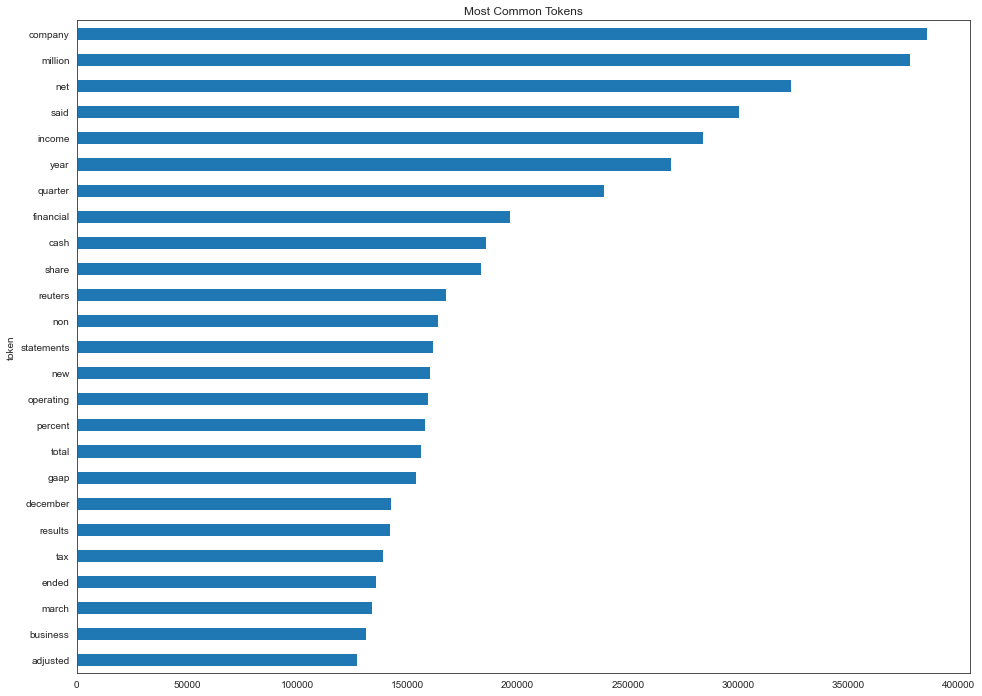

In [41]:
most_common = (pd.DataFrame(vocab.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

most_common.head(25).set_index('token')['count'].sort_values().plot.barh(title='Most Common Tokens', figsize=(16, 12));

In [57]:
clean_article_path.as_posix()  # pahtlib package

'results/financial_news/articles_clean.txt'

In [24]:
# Create n-grams
max_length = 3
n_grams = pd.DataFrame()
start = time()

sentences = LineSentence(clean_article_path.as_posix())
for n in range(2, max_length + 1):
    print(n, end=' ')
    if n>2:
        sentences = LineSentence((results_path / f'articles_{n-1}_grams.txt').as_posix())
    # only phrases with higher score
    # min_count : ignore terms with a lower count
    phrases = Phrases(sentences, threshold=100, min_count=10)

    # phrases.export_phrases() usage has been changed
    s = pd.Series({k : v for k, v in phrases.export_phrases().items()})
    s = s.to_frame('score').reset_index().rename(columns={'index': 'phrase'}).assign(length=n)

    n_grams = pd.concat([n_grams, s])
    grams = Phraser(phrases)
    sentences = grams[sentences]

    # because of Ver.Kor Windows user, encoding is mandatory to UTF-8 from CP949
    with (results_path / f'articles_{n}_grams.txt').open('w', encoding='UTF8') as f:
        for sentence in sentences:
            f.write(' '.join(sentence) + '\n')

n_grams = n_grams.sort_values('score', ascending=False)
n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

print('\n\tDuration: ', format_time(time() - start))
print(f'\tngrams: {len(n_grams):,d}\n')
print(n_grams.groupby('length').size())

2 3 
	Duration:  00:04:14
	ngrams: 66,468

length
2    29501
3    36967
dtype: int64


In [46]:
n_grams.sample(10)

,phrase,score,length,ngram
1441,remains shrouded,489.55,3,remains_shrouded
34710,sawa eastern,504.71,3,sawa_eastern
27524,schull nic,"2,870.25",2,schull_nic
2865,stress test,150.62,3,stress_test
4659,simon cameron,"1,746.29",2,simon_cameron
26690,xeljanz xeljanz,"23,484.26",3,xeljanz_xeljanz
2656,archer daniels,"4,090.18",2,archer_daniels
21373,safely efficiently,271.60,3,safely_efficiently
18095,jimmie blotter pahl shipley,"35,081.43",3,jimmie_blotter_pahl_shipley
11051,musculoskeletal healing,480.11,2,musculoskeletal_healing


In [25]:
n_grams.groupby('length').apply(lambda x: x.nlargest(10, 'score'))

phrase            score  length  \
length                                                              
2      24827          bruckhaus deringer       182,440.40       2   
       12365       pracha hariraksapitak       182,440.40       2   
       19269               citigate dewe       182,440.40       2   
       25805  mukhammadsharif mamatkulov       182,440.40       2   
       13976    hidradenitis suppurativa       182,440.40       2   
       29232                nidaa tounes       182,026.70       2   
       27458            navesh chitrakar       182,026.70       2   
       24385      axalimogene filolisbac       182,026.70       2   
       21537             koustav samanta       182,026.70       2   
       27908     munkhchimeg davaasharav       181,935.02       2   
3      73                   kuala lumpur 1,395,223,390.50       3   
       7847              sanjana shivdas   719,870,860.00       3   
       4112              marguerita choy   422,450,531.00       3   
       94            petroleo brasileiro   358,672,498.67       3   
       20970            aeterna zentaris   333,413,872.00       3   
       6613                   dado ruvic   308,349,542.46       3   
       14040                kaori kaneko   231,116,434.00       3   
       5463           abhinav ramnarayan   229,222,037.00       3   
       5822                 fathin ungku   214,066,861.00       3   
       9966                 leika kihara   209,330,868.50       3   

                                   ngram  
length                                    
2      24827          bruckhaus_deringer  
       12365       pracha_hariraksapitak  
       19269               citigate_dewe  
       25805  mukhammadsharif_mamatkulov  
       13976    hidradenitis_suppurativa  
       29232                nidaa_tounes  
       27458            navesh_chitrakar  
       24385      axalimogene_filolisbac  
       21537             koustav_samanta  
       27908     munkhchimeg_davaasharav  
3      73                   kuala_lumpur  
       7847              sanjana_shivdas  
       4112              marguerita_choy  
       94            petroleo_brasileiro  
       20970            aeterna_zentaris  
       6613                   dado_ruvic  
       14040                kaori_kaneko  
       5463           abhinav_ramnarayan  
       5822                 fathin_ungku  
       9966                 leika_kihara